# Audio and text preprocessing

In order to map text input to output, it is necessary to create a set of valid characters and extract linear and mel spectrograms from audio. Each pair text-audio consists of an int array that represents the text (input) and the spectrograms (outputs to be optimized).

## MXNet DataLoader

MXNet DataLoader can take numpy arrays and feed batches to the trainer. In this toy example we create random numpy arrays to populate the loader. Later on, we would like it to feed data to the trainer.

However, since we will have lists of different lengths, the dataloader may not be the best choice.

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

C:\Users\dougl_000\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lstChars = np.zeros([1,15], dtype=int)
lstSTFT  = np.zeros([1,8,6])

In [3]:
for i in range(10):
    lstChars = np.append(lstChars, [np.random.randint(25, size=15)], axis=0)
    lstSTFT  = np.append(lstSTFT, [np.random.randn(8,6)], axis=0)

In [4]:
print(lstChars[3])
print(lstSTFT[3])
lstSTFT.shape

[ 7 16  9 11 18 10  1 20 17 13  8 19  2  2 17]
[[ 0.5196522   1.34636236  0.64883484 -0.05283772  0.29746114  2.53710251]
 [ 0.72522785 -0.31741509  0.03609027  0.74691597  2.01471567  1.42158251]
 [ 0.56275827  0.70219763 -1.25641798  0.14179379 -0.74085984 -0.64615711]
 [ 1.14138049  0.09071766 -1.60880464 -1.55033745  0.7154189   0.10850234]
 [-0.59706388  1.33649811 -0.28446513  0.59768377 -1.33073443 -0.60388499]
 [ 0.32879862  2.2705422  -0.22895231 -1.61888133  1.76260027  1.61181324]
 [-0.53698631  0.41043972 -0.84648525  0.69419968 -1.39964796  2.02229723]
 [-1.79017054 -0.54345774 -0.35173192 -0.10854053  1.14578888 -1.20260105]]


(11, 8, 6)

In [5]:
dataset = mx.gluon.data.dataset.ArrayDataset(lstChars, lstSTFT)
sample = dataset[3]
print(sample)

(array([ 7, 16,  9, 11, 18, 10,  1, 20, 17, 13,  8, 19,  2,  2, 17]), array([[ 0.5196522 ,  1.34636236,  0.64883484, -0.05283772,  0.29746114,
         2.53710251],
       [ 0.72522785, -0.31741509,  0.03609027,  0.74691597,  2.01471567,
         1.42158251],
       [ 0.56275827,  0.70219763, -1.25641798,  0.14179379, -0.74085984,
        -0.64615711],
       [ 1.14138049,  0.09071766, -1.60880464, -1.55033745,  0.7154189 ,
         0.10850234],
       [-0.59706388,  1.33649811, -0.28446513,  0.59768377, -1.33073443,
        -0.60388499],
       [ 0.32879862,  2.2705422 , -0.22895231, -1.61888133,  1.76260027,
         1.61181324],
       [-0.53698631,  0.41043972, -0.84648525,  0.69419968, -1.39964796,
         2.02229723],
       [-1.79017054, -0.54345774, -0.35173192, -0.10854053,  1.14578888,
        -1.20260105]]))


In [6]:
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()
print(CPU_COUNT)
data_loader = mx.gluon.data.DataLoader(dataset, batch_size=5, num_workers=CPU_COUNT)

4


In [7]:
for X_batch, y_batch in data_loader:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

X_batch has shape (5, 15), and y_batch has shape (5, 8, 6)
X_batch has shape (5, 15), and y_batch has shape (5, 8, 6)
X_batch has shape (1, 15), and y_batch has shape (1, 8, 6)


# Preprocessing text

Lowercase and uppercase make difference in the original Tacotron. Will this increase complexity by too much?

Set up valid characters and encoding.

In [8]:
%run preprocess.py

In [9]:
ppt = PreProcessText('lowercaseonly')
#ppt.Encode('This is a test')

In [10]:
xx = ppt.Encode('This is a  == test')
print(xx.dtype)
xx

int32


array([25, 13, 14, 24,  0, 14, 24,  0,  6,  0,  0,  2,  2,  0, 25, 10, 24,
       25])

## Nancy Dataset

In the case of the Nancy corpus http://www.cstr.ed.ac.uk/projects/blizzard/2011/lessac_blizzard2011/ the file corrected.gui contains all text that will be needed and the reference to the proper files.

Let us choose for now 200 max characters, 500 max spectrogram columns. That seems to match the Nancy dataset.

### Importing file labels

In [11]:
numFFT = 1025
numMel = 80

In [12]:
nancyTexts = 'blizz2011Nancy/corrected.gui'
with open(nancyTexts, 'r') as nancyFile:
    data = nancyFile.read()

data = data.split('\n')


In [14]:
files = []
texts = []
lstTextEncodings = []

numTexts = len(data)//3
for i in range(numTexts):
    files.append(data[3*i])
    texts.append(data[3*i+1])
    encodedText = ppt.Encode(data[3*i+1])
    #encodedText = np.pad(encodedText,pad_width=(0, numChars-len(encodedText)), mode='constant', constant_values=(0, 0))
    
    #lstTextEncodings = np.append(lstTextEncodings, [encodedText], axis = 0)
    lstTextEncodings.append(encodedText)
    
    if (i % 1000 == 0):
        print('Importing dataset strings: {} %'.format(100*i/numTexts // 1), end='\r')

#lstTextEncodings = lstTextEncodings[1:] #remove first item
print('Done importing Nancy dataset texts')

Done importing Nancy dataset texts


In [17]:
print(texts[540])
print(files[540])
print(lstTextEncodings[540])

Sometimes he had to travel for extended periods on behalf @ of his company , @ # leaving Lily @ feeling once again like a single parent . # 
HAW-206-01
[24 20 18 10 25 14 18 10 24  0 13 10  0 13  6  9  0 25 20  0 25 23  6 27
 10 17  0 11 20 23  0 10 29 25 10 19  9 10  9  0 21 10 23 14 20  9 24  0
 20 19  0  7 10 13  6 17 11  0  2  0 20 11  0 13 14 24  0  8 20 18 21  6
 19 30  0  3  0  2  0  2  0 17 10  6 27 14 19 12  0 17 14 17 30  0  2  0
 11 10 10 17 14 19 12  0 20 19  8 10  0  6 12  6 14 19  0 17 14 16 10  0
  6  0 24 14 19 12 17 10  0 21  6 23 10 19 25  0  4  0  2  0]


### Import spectrograms and mel-spectrograms

Below is a toy code to show that the WAVs are being imported correctly.

In [18]:
from util import audio
import matplotlib.pyplot as plt

C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\dougl_000\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getar

In [20]:
fileToLoad = 'blizz2011Nancy/wavn/' + files[42] + '.wav'
fileToLoad

'blizz2011Nancy/wavn/HAW-026-01.wav'

In [21]:
# Load the audio to a numpy array:
wav = audio.load_wav(fileToLoad)

In [22]:
%%time

#Compute the linear-scale spectrogram from the wav:
spectrogram = audio.spectrogram(wav).astype(np.float32)
mel_spectrogram = audio.melspectrogram(wav).astype(np.float32)
print(spectrogram.shape)

(1025, 666)
Wall time: 336 ms


In [24]:
print(spectrogram.shape)
#spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, numSpect-spectrogram.shape[1])) , mode='constant', constant_values=(0, 0))
spectrogram.shape

(1025, 666)


(1025, 666)

In [25]:
print(mel_spectrogram.shape)
#mel_spectrogram = np.pad(mel_spectrogram,pad_width=((0, 0), (0, numSpect-mel_spectrogram.shape[1])) , mode='constant', constant_values=(0, 0))
mel_spectrogram.shape

(80, 666)


(80, 666)

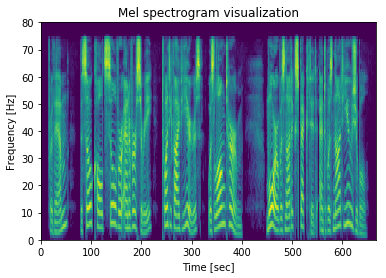

In [27]:
plt.pcolormesh(mel_spectrogram)
plt.title('Mel spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Now we really create the spectrograms and mel-spectrograms

In [28]:
lst_linspectrograms = []
lst_melspectrograms = []
from pathlib import Path
i = 0
numTexts = len(files)
for f in files:
    fileToLoad = 'blizz2011Nancy/wavn/' + f + '.wav'
    
    if Path(fileToLoad).is_file():
        wav = audio.load_wav(fileToLoad)
    else:
        wav = np.zeros(4000)
        print('Cannot find file no. {}'.format(i) + fileToLoad)
        
    spectrogram = audio.spectrogram(wav).astype(np.float32)
    mel_spectrogram = audio.melspectrogram(wav).astype(np.float32)
    
    #padding
    #targW = ((0, 0), (0, numSpect-spectrogram.shape[1]));
    #spectrogram = np.pad(spectrogram, pad_width=targW, mode='constant', constant_values=(0, 0))
    #mel_spectrogram = np.pad(mel_spectrogram, pad_width=targW, mode='constant', constant_values=(0, 0))

    
    lst_linspectrograms.append(spectrogram) #= np.append(lst_linspectrograms, [spectrogram], axis=0)
    lst_melspectrograms.append(mel_spectrogram) # = np.append(lst_melspectrograms, [mel_spectrogram], axis=0)
    i = i + 1
    if (i % 100 == 0):
        print('Importing dataset audios: {} '.format(100*i/numTexts // 1), end='\r')

print('Done importing dataset audios')    



Cannot find file no. 55blizz2011Nancy/wavn/HAW-032-04.wav
Cannot find file no. 59blizz2011Nancy/wavn/HAW-033-03.wav
Cannot find file no. 88blizz2011Nancy/wavn/HAW-046-00.wav
Cannot find file no. 90blizz2011Nancy/wavn/HAW-047-00.wav
Cannot find file no. 118blizz2011Nancy/wavn/HAW-055-01.wav
Cannot find file no. 124blizz2011Nancy/wavn/HAW-056-03.wav
Cannot find file no. 126blizz2011Nancy/wavn/HAW-060-01.wav
Cannot find file no. 137blizz2011Nancy/wavn/HAW-063-01.wav
Cannot find file no. 144blizz2011Nancy/wavn/HAW-066-00.wav
Cannot find file no. 148blizz2011Nancy/wavn/HAW-067-01.wav
Cannot find file no. 162blizz2011Nancy/wavn/HAW-071-02.wav
Cannot find file no. 176blizz2011Nancy/wavn/HAW-077-03.wav
Cannot find file no. 219blizz2011Nancy/wavn/HAW-092-02.wav
Cannot find file no. 233blizz2011Nancy/wavn/HAW-096-04.wav
Cannot find file no. 254blizz2011Nancy/wavn/HAW-111-02.wav
Cannot find file no. 277blizz2011Nancy/wavn/HAW-122-01.wav
Cannot find file no. 299blizz2011Nancy/wavn/HAW-129-01.wav
C

KeyboardInterrupt: 

In [29]:
#cut first element
#lst_linspectrograms = lst_linspectrograms[1:]
#lst_melspectrograms = lst_melspectrograms[1:]

In [31]:
len(lst_linspectrograms) #.shape

812

So it may be that # while men are still @ feeling in a positive role as wage earners and producers , # and receiving gratification @ from this , # they may be more able @ to mask or deny or sublimate health symptoms . # 


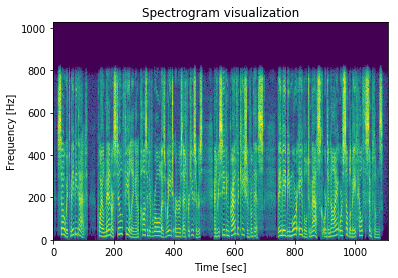

In [32]:
#sanity check
print(texts[123])
spectrogram = lst_linspectrograms[123]
plt.pcolormesh(spectrogram)
plt.title('Spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [33]:
%%time
reconst_wav = audio.inv_spectrogram(spectrogram)

C:\Users\dougl_000\Anaconda3\lib\site-packages\librosa\util\utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


Reconstructing with 60 iterations
Wall time: 21.7 s


In [35]:
audio.save_wav(path='data/reconstrSANITY.wav', wav=reconst_wav)

# Save data to disk

In [37]:
import pickle
pickle.dump(lstTextEncodings, open( 'data/lsttxtencodings.p', "wb" ) )
pickle.dump(lst_linspectrograms, open( 'data/lstlinspectrograms.p', "wb" ) )
pickle.dump(lst_melspectrograms, open( 'data/lstmelspectrograms.p', "wb" ) )

In [242]:
#save everything
#np.save('data/lsttxtencodings.p', lstTextEncodings)

In [243]:
#np.save('data/lstlinspectrograms.npy', lst_linspectrograms)
#np.save('data/lstmelspectrograms.npy', lst_melspectrograms)

In [6]:
#reconst_wav = np.load('reconstrSANITY.npy')